In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [242]:
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
import time
from utils import import_data, compute_KNN_graph, create_batch,reconstruct_symmetric_matrix, read_motion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

scoring = {'mae': 'neg_mean_absolute_error',
           'mse': 'neg_mean_squared_error',
          'r2' : 'r2'} 

In [498]:
df = pd.read_csv("/Users/rodrigo/Post-Grad/Ising_GNN/result.csv").dropna()

df.head()

df = df[df['Max Motion (mm)'] < 5]

In [499]:
print('correlation Temperature and Age = {}'.format(np.corrcoef([df['Temperature'], df['Age']])[0,1]))

correlation Temperature and Age = -0.34320116550631624


In [500]:
print('correlation Temperature and Max Motion = {}'.format(np.corrcoef([df['Temperature'], df['Max Motion (mm)']])[0,1]))

correlation Temperature and Max Motion = 0.22754855114852643


In [552]:
# X = df[['Age', 'Max Motion (mm)']]#, 'Gender', 'DX']]
# y = df['Temperature']

X = df[['Max Motion (mm)', 'Temperature', 'Gender', 'DX']]
y = df['Age']

X['Max Motion (mm)'] = np.log(X['Max Motion (mm)']) + 0.00001

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
y = (y - y.min(axis=0)) / (y.max(axis=0) - y.min(axis=0))

/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_2906/810814169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Max Motion (mm)'] = np.log(X['Max Motion (mm)']) + 0.00001


In [553]:
# plt.hist(X.Age, alpha=0.5)
# plt.hist(X['Max Motion (mm)'], alpha=.5)
# plt.hist(y, alpha=.6)
# plt.show()

In [554]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True).fit(X,y)
reg.score(X, y)

0.12255487449734392

In [555]:
reg.coef_

array([-0.06172894, -0.92499361,  0.01364721, -0.01775765])

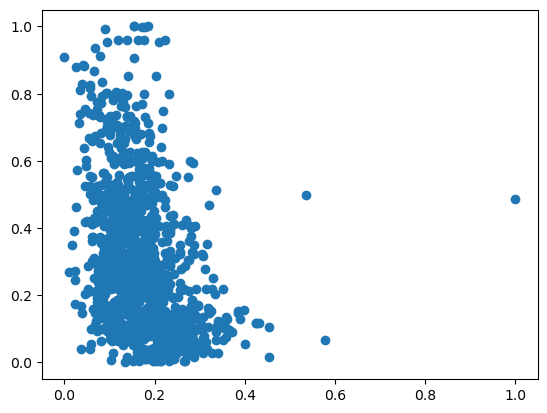

In [558]:
plt.scatter(X['Temperature'], y)

In [556]:
import statsmodels.api as sm

#X = sm.add_constant(X)
mod = sm.OLS(y, X).fit()


In [557]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Age   R-squared (uncentered):                   0.581
Model:                            OLS   Adj. R-squared (uncentered):              0.580
Method:                 Least Squares   F-statistic:                              386.4
Date:                Fri, 20 Oct 2023   Prob (F-statistic):                   1.12e-208
Time:                        16:35:14   Log-Likelihood:                         -24.022
No. Observations:                1117   AIC:                                      56.04
Df Residuals:                    1113   BIC:                                      76.12
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Max Motion (mm)     0.3654      0.028     12.961      0.000       0.310       0.421
Temperature         0.0457      0.081      0.565      0.572      -0.113       0.205
Gender              0.1070      0.015      7.221      0.000       0.078       0.136
DX                  0.0026      0.021      0.120      0.904      -0.039       0.044
==============================================================================
Omnibus:                       92.065   Durbin-Watson:                   0.624
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.335
Skew:                           0.761   Prob(JB):                     2.45e-25
Kurtosis:                       3.340   Cond. No.                         10.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [548]:
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.inspection import permutation_importance


svm = svm.SVR(kernel='linear',C=1)
svm.fit(X,y)

from sklearn.model_selection import cross_val_score
scores = cross_validate(svm, X, y, cv=10 ,scoring=scoring, n_jobs=-1)
print('mae', scores['test_mae'].mean())
print('r2', scores['test_r2'].mean())


mae -0.16841068960377098
r2 -0.8799230727820255


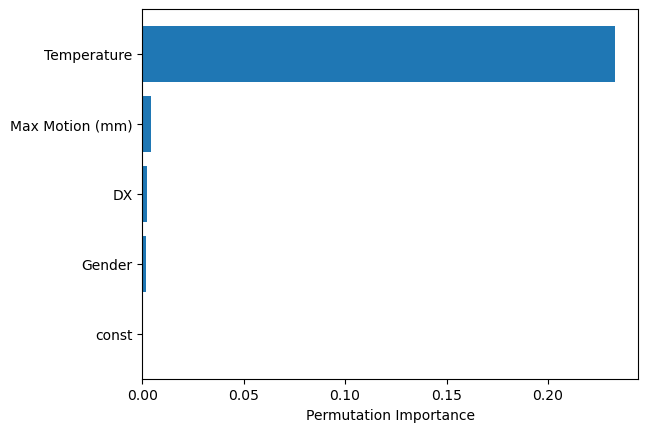

In [549]:
perm_importance = permutation_importance(svm, X, y)

feature_names = X.columns.values
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [550]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, y)
regr.score(X,y)

scores = cross_validate(regr, X, y, cv=10 ,scoring=scoring, n_jobs=-1)
print('mae', scores['test_mae'].mean())
print('r2', scores['test_r2'].mean())

mae -0.1708564538646754
r2 -1.1240650241402246


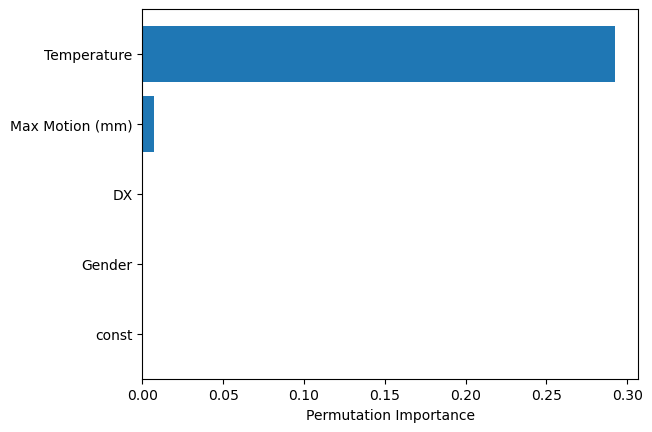

In [551]:
perm_importance = permutation_importance(regr, X, y)

feature_names = X.columns.values
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()